In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import leidenalg
import pandas as pd
plt.style.use('ggplot')

# Unsupervised Learning: Community Detection

The problem of finding groups of nodes in networks is called community detection. Simple though it is to describe, community detection turns out to be a challenging task, but a number of methods have been developed that return good results in practical situations.

In particular it would be interesting to check if:
- which percentage of nodes in the same cluster belong to the the same category of video
- if one user tends to stay in just one cluster
- what are the average statistics for each cluster

In [12]:
#import edges
edges = pd.read_csv("edges.csv", sep = "\t")
edges.columns = ["source", "target"]
edges.head(3)

,source,target
0,2rwktobtv9s,IqlxYO7YCI8
1,2rwktobtv9s,FkKWCBWVwQg
2,2rwktobtv9s,FyuYJsBavBs


In [4]:
#import nodes info
nodes = pd.read_csv("youtube_raw.csv").drop("id.1",axis = 1)

#eliminate recommendations
nodes = nodes.iloc[:,0:9]

In [13]:
#import the complete graph
graph = nx.from_pandas_edgelist(edges)



In [15]:
def GetInfoGraph(G):
    print('number of edges', G.number_of_edges())
    print('number of nodes', G.number_of_nodes())
    print('min degree', np.min([degree[1] for degree in G.degree()])) # minimum degree
    print('max degree', np.max([degree[1] for degree in G.degree()]))# maximum degree
    #print('VERTICES', G.nodes())
    #print('EDGES', G.edges())
    print('Is connected ?', nx.is_connected(G))
    print('number of connected components: ', nx.number_connected_components(G))
   

GetInfoGraph(graph)

number of edges 855270
number of nodes 154815
min degree 1
max degree 332
Is connected ? False
number of connected components:  7


In [16]:
#take strongest connected component
#retrieve largest connected component
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
G0 = graph.subgraph(Gcc[0])

#convert it to igraph
g = ig.Graph.from_networkx(G0)

In [17]:
# replace name
g.vs["name"] = g.vs["_nx_name"]
del(g.vs["_nx_name"])

# check if named
g.is_named()

True

# Leiden Algorithm
Traag, V.A., Waltman. L., Van Eck, N.-J. (2018). From Louvain to Leiden: guaranteeing well-connected communities. Scientific reports, 9(1), 5233. 10.1038/s41598-019-41695-z

Leiden algorithms is an extension of **Louvain Algorithm**

Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 10008(10), 6. 10.1088/1742-5468/2008/10/P10008

## Modularity Vertex Partitition
Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure in networks. Physical Review E, 69(2), 026113. 10.1103/PhysRevE.69.026113

In [18]:
part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

In [19]:
#compute the modularity of the partition
part.modularity

0.9366140866267549

In [20]:
count = 0
comm = []
for i in list(part):
    count+=1
    comm.append([count, len(i)])

In [21]:
#tot number of communities found
part.__len__()

275

In [22]:
count= pd.DataFrame(comm, columns=["Community", "Nb_edges"])

Text(0, 0.5, 'Count')

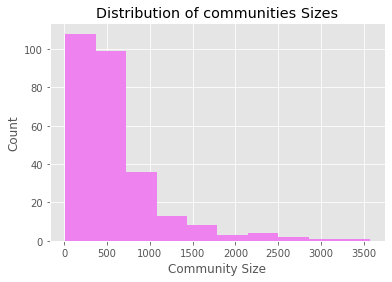

In [25]:
plt.hist(x = count.Nb_edges, color = "violet")
plt.title("Distribution of communities Sizes")
plt.xlabel("Community Size")
plt.ylabel("Count")

In [26]:
#shrink each community as a node and plot them
communities_graph = part.cluster_graph()

layout = communities_graph.layout("fruchterman_reingold")
ig.plot(communities_graph, layout=layout,vertex_size=8,
        vertex_color="violet")

# Analysis of the communities

In [27]:
#create dataframe with all nodes
communities = pd.DataFrame(g.vs["name"], columns = ["id"])
#get membership of each node
communities["community"] = part.membership


In [28]:
#perform a left join with node_info
communities = communities.merge(nodes, how='left')
communities.head(3)

,id,community,uploader,age,category,length,views,rate,ratings,comments
0,2rwktobtv9s,219,EA,742.0,Gadgets & Games,83.0,389536.0,2.65,2294.0,268.0
1,IqlxYO7YCI8,219,EA,738.0,Gadgets & Games,60.0,166.0,5.00,2.0,0.0
2,FkKWCBWVwQg,219,EA,738.0,Gadgets & Games,63.0,205.0,3.25,4.0,0.0


In [29]:
category_comm = communities.groupby(["community", "category"]).count().id.reset_index()

In [30]:
#get percentage of each category in each community
#we want to see if in each community there is a predominant category or if each community contains videos of any genre

def get_percentage(row):
    return (row['id'] / category_comm.loc[category_comm.community == row["community"],'id'].sum()) * 100

In [31]:
category_comm["percentage"] = category_comm.apply(lambda x: get_percentage(x), axis = 1)

In [32]:
#get the most common category for each community with the corresponding percentage of nodes inside that category
most_common = category_comm.groupby("community").max().reset_index()
most_common.head(5)

,community,category,id,percentage
0,0,Travel & Places,2663,74.635650
1,1,Travel & Places,672,22.119816
2,2,Travel & Places,2237,81.168360
3,3,Travel & Places,693,26.420130
4,4,Travel & Places,1914,77.868186


([<matplotlib.axis.XTick at 0x23c451c8580>,
 [Text(20, 0, '20%'),
  Text(40, 0, '40%'),
  Text(60, 0, '60%'),
  Text(80, 0, '80%'),
  Text(100, 0, '100%')])

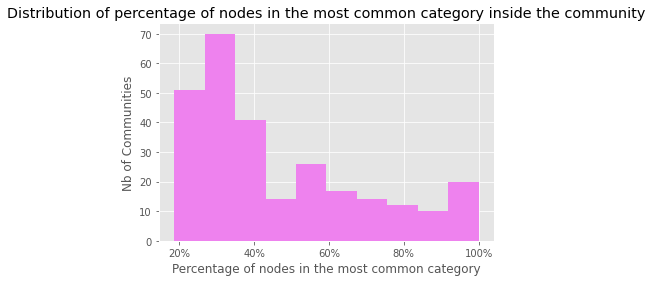

In [33]:
import matplotlib.ticker as mtick
plt.hist(most_common.percentage, color = "violet")
plt.title("Distribution of percentage of nodes in the most common category inside the community")
plt.xlabel("Percentage of nodes in the most common category")
plt.ylabel("Nb of Communities")
plt.xticks(ticks = [20,40,60,80,100], labels = ["20%", "40%", "60%", "80%", "100%"])

In [34]:
#get how many communities for each category
#considering the most common community
nb_comm_by_category = most_common.groupby("category").count().community.reset_index()
nb_comm_by_category

,category,community
0,Entertainment,2
1,Film & Animation,2
2,Gadgets & Games,2
3,Howto & DIY,1
4,Music,10
5,News & Politics,2
6,People & Blogs,16
7,Pets & Animals,2
8,Sports,25
9,Travel & Places,213


Text(0.5, 1.0, 'Number of communities for each category')

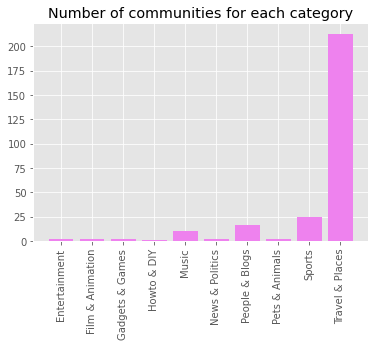

In [35]:
#however this graph is not really representative, and probably misleading
plt.bar(nb_comm_by_category.category, height=nb_comm_by_category.community, color = "violet")
plt.xticks(rotation = 90)
plt.title("Number of communities for each category")

In [36]:
#try to understand the distributuon of the nb of communities for each uploader
#does the same uploader have the tendency to be recommended in just one community of videos of multiple ones?
nb_community_by_uploader = communities.groupby(["uploader","community"]).count().id.reset_index().groupby("uploader").count().community.reset_index()
nb_community_by_uploader.columns = ["uploader", "nb_communities"]

In [37]:
#get percentage of uploaders that participate in a certain number of communities
nb_uploader_by_nb_communities = nb_community_by_uploader.groupby("nb_communities").count().reset_index()
nb_uploader_by_nb_communities["percentage"] = nb_uploader_by_nb_communities.apply(lambda row: (row['uploader'] / nb_uploader_by_nb_communities.uploader.sum()) * 100, axis = 1)

In [38]:
nb_uploader_by_nb_communities
#93% percentage of youtube channels are part of just of one communities (their videos are all reccomended in just one community)
#almost 6% in 2
#less than 1% in 3
# the remaming (less than 1%)in more than 3

,nb_communities,uploader,percentage
0,1,90673,92.794277
1,2,5630,5.761713
2,3,962,0.984506
3,4,256,0.261989
4,5,102,0.104386
5,6,33,0.033772
6,7,21,0.021491
7,8,17,0.017398
8,9,5,0.005117
9,10,4,0.004094
